In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numba import config, cuda
from PIL import Image
config.CUDA_ENABLE_PYNVJITLINK = 1

In [12]:
def load_image(path):
    img = Image.open(path).convert('L')  # wczytanie obrazu i konwersja do skali szarości
    arr = np.array(img, dtype=np.float32)  # konwersja do macierzy zawierającej wartości pikseli
    return arr

Dwuwymiarowy splot obrazu polega na przesunięciu kwadratowego filtra po całym obrazie. Dla każdego piksela wynikowego obliczamy sumę iloczynów wartości pikseli w oknie filtra i odpowiadających im wag w jądrze.

In [13]:
@cuda.jit
def image_2d_convolution(input_image, filter, output_image):
    x, y = cuda.grid(2)  # x = blockIdx.x * blockDim.x + threadIdx.x
    height, width = input_image.shape  # wymiary obrazu
    filter_width = filter.shape[0]  # szerokość kwadratowego filtra
    half_width = filter_width // 2  # połowa szerokości filtra (do wyśrodkowania okna)
    weigted_sum = 0.0  # suma ważona dla piksela

    if x < width and y < height: # sprawdzenie, czy wątek jest w obszarze obrazu
        for fy in range(filter_width):  # iteracja po wierszach filtra
            for fx in range(filter_width):  # iteracja po kolumnach filtra
                idx_x = x + fx - half_width  # przesunięcie w poziomie
                idx_y = y + fy - half_width  # przesunięcie w pionie
                if 0 <= idx_x < width and 0 <= idx_y < height:  # sprawdzenie, czy indeksy są w granicach obrazu
                    weigted_sum += input_image[idx_y, idx_x] * filter[fy, fx]  # dodanie do sumy: wartość piksela * waga filtra
        output_image[y, x] = weigted_sum  # zapisanie obliczonej wartości do obrazu wyjściowego

Wczytanie pliku i wyznaczenie siatki bloków i wątków

In [14]:
input_img = load_image('landscape.jpg')
height, width = input_img.shape
nthreads = 32
nblocksy = (height // nthreads) + 1
nblocksx = (width // nthreads) + 1
config = (nblocksx, nblocksy), (nthreads, nthreads)

Wyświetlenie obrazu wejściowego (w skali szarości)

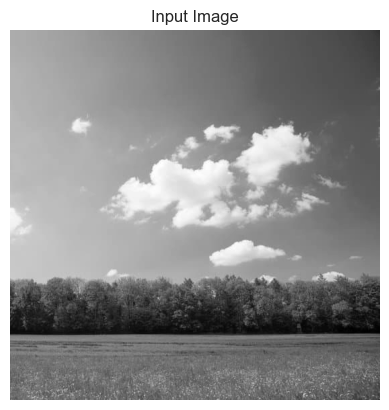

In [15]:
plt.figure()
plt.imshow(input_img, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

Przykładowe filtry

In [16]:
blur = np.ones((5, 5))
emboss = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1 , 2]])
sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1 , 0]])

Alokacja macierzy na obraz wyjściowy

In [17]:
output_img = np.zeros_like(input_img)

Obraz wyjściowy - filtr rozmywający

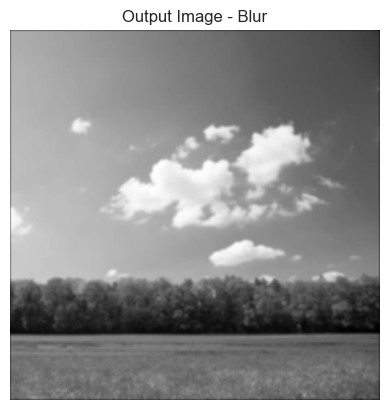

In [18]:
d_input = cuda.to_device(input_img)
d_filter = cuda.to_device(blur)
d_output = cuda.to_device(output_img)

image_2d_convolution[config](d_input, d_filter, d_output)

d_output.copy_to_host(output_img)

plt.figure()
plt.imshow(output_img, cmap='gray')
plt.title('Output Image - Blur')
plt.axis('off')
plt.show()

Obraz wyjściowy - filtr wytłaczający

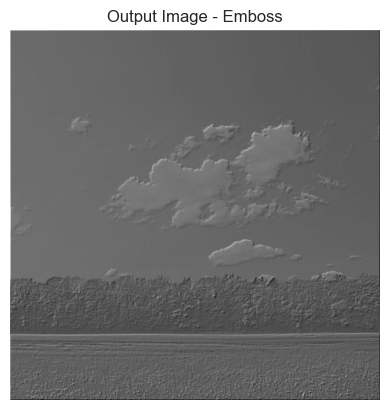

In [19]:
d_input = cuda.to_device(input_img)
d_filter = cuda.to_device(emboss)
d_output = cuda.to_device(output_img)

image_2d_convolution[config](d_input, d_filter, d_output)

d_output.copy_to_host(output_img)

plt.figure()
plt.imshow(output_img, cmap='gray')
plt.title('Output Image - Emboss')
plt.axis('off')
plt.show()

Obraz wyjściowy - filtr wyostrzający

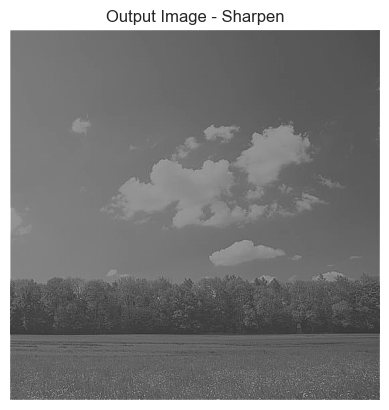

In [20]:
d_input = cuda.to_device(input_img)
d_filter = cuda.to_device(sharpen)
d_output = cuda.to_device(output_img)

image_2d_convolution[config](d_input, d_filter, d_output)

d_output.copy_to_host(output_img)

plt.figure()
plt.imshow(output_img, cmap='gray')
plt.title('Output Image - Sharpen')
plt.axis('off')
plt.show()